#### Will be moved to exploration branch

Based of scores-sepehr, goal is to see how to create an interactive table of top 5 directors per country for the datastory

In [1]:
from helpers.readers import read_dataframe_parquet, read_dataframe

In [2]:
%%time
cmu_movies_og = read_dataframe("cmu/movies")

CPU times: total: 297 ms
Wall time: 295 ms


In [3]:
%%time
cmu_movies = read_dataframe_parquet("cmu/movies")

CPU times: total: 156 ms
Wall time: 85.3 ms


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.readers import prepare_dataframes

In [5]:
%%time
#movies, directors, awards = prepare_dataframes(use_parquet=False, save=True)

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
%%time
#movies, directors, awards = prepare_dataframes(use_parquet=True, save=True)

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
movies = read_dataframe_parquet("merged/movies")
directors = read_dataframe_parquet("merged/directors")
awards = read_dataframe_parquet("merged/awards")

In [8]:
all_countries = movies["countries"]
split_countries = all_countries.str.split(',')
flat_list = [country.strip() for sublist in split_countries for country in sublist]
countries = sorted(set(flat_list))
print(f'We have movies from {len(countries)} countries in the world.')

We have movies from 143 countries in the world.


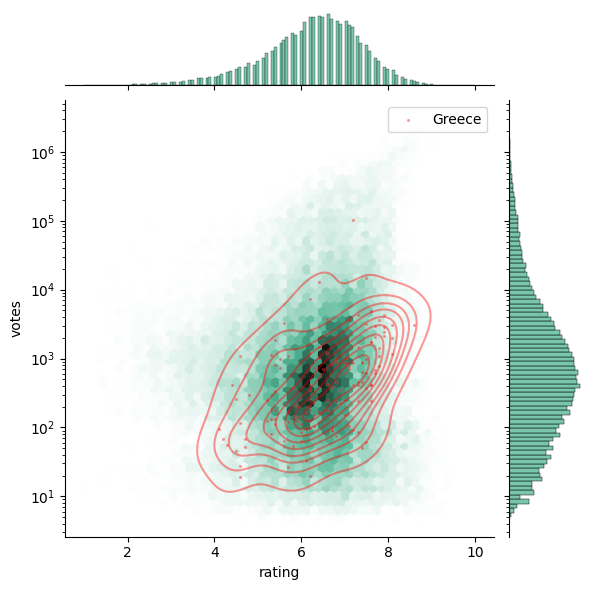

In [9]:
# NOTE: This can be an interactive plot in the final data story

for country in ['Greece']:#, 'Egypt', 'Argentina', 'Pakistan', 'Philippines']:
    g = sns.jointplot(x=movies.rating, y=movies.votes, kind='hex', color="#4CB391", joint_kws={'yscale': 'log'})
    df = movies[movies.countries.str.contains(country) & ~movies.countries.str.contains(',')]
    sns.scatterplot(x=df.rating, y=df.votes, color='r', alpha=.4, s=5, ax=g.ax_joint, label=country)
    sns.kdeplot(x=df.rating, y=df.votes, color='r', alpha=.4, ax=g.ax_joint)
    g.ax_joint.legend()

## Plotly interactive for website

In [17]:
%%time
from tqdm.notebook import tqdm

for country in tqdm(countries[1:]):
    g = sns.jointplot(x=movies.rating, y=movies.votes, kind='hex', color="#4CB391", joint_kws={'yscale': 'log'})
    df = movies[movies.countries.str.contains(country) & ~movies.countries.str.contains(',')]
    sns.scatterplot(x=df.rating, y=df.votes, color='r', alpha=.4, s=5, ax=g.ax_joint, label=country)
    sns.kdeplot(x=df.rating, y=df.votes, color='r', alpha=.4, ax=g.ax_joint)
    g.ax_joint.legend()

    plt.savefig(f"docs/assets/figs/rating_votes_plots/{country}.png", bbox_inches='tight')
    plt.close()

  0%|          | 0/142 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
<timed exec>:7: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
<timed exec>:7: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
<timed exec>:7: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
<timed exec>:7: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singul

CPU times: total: 8min 57s
Wall time: 9min 8s


In [19]:
html_options = ['<option value="">Select a country</option>']

for country in countries[1:]:
    selected_attribute = ' selected' if country == "United States of America" else ''
    option = f'<option value="{country}"{selected_attribute}>{country}</option>'
    html_options.append(option)

# Join all options to form the final HTML string
final_html = '\n    '.join(html_options)
print(final_html)

<option value="">Select a country</option>
    <option value="Afghanistan">Afghanistan</option>
    <option value="Albania">Albania</option>
    <option value="Algeria">Algeria</option>
    <option value="Argentina">Argentina</option>
    <option value="Armenia">Armenia</option>
    <option value="Aruba">Aruba</option>
    <option value="Australia">Australia</option>
    <option value="Austria">Austria</option>
    <option value="Azerbaijan">Azerbaijan</option>
    <option value="Bahamas">Bahamas</option>
    <option value="Bahrain">Bahrain</option>
    <option value="Bangladesh">Bangladesh</option>
    <option value="Belgium">Belgium</option>
    <option value="Bhutan">Bhutan</option>
    <option value="Bolivia">Bolivia</option>
    <option value="Bosnia and Herzegovina">Bosnia and Herzegovina</option>
    <option value="Brazil">Brazil</option>
    <option value="Bulgaria">Bulgaria</option>
    <option value="Burkina Faso">Burkina Faso</option>
    <option value="Burma">Burma</option>

## Movie Score

In [ ]:
%%time
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1) # to vectorize

In [ ]:
def list_top_movies(country: str, top=5):
    cols = ['title', 'score', 'rating', 'votes', 'revenue', 'release', 'genres']
    display(movies[movies.countries.str.contains(country)].sort_values(by='score', ascending=False)[:top][cols])

In [ ]:
list_top_movies('Iran', top=5)

## Director score

In [ ]:
movies_exploded = movies.reset_index(drop=False).copy()

movies_exploded['directors'] = movies_exploded['directors'].str.split(',')
movies_exploded = movies_exploded.explode('directors')

In [ ]:
directors.reset_index(inplace=True)
director_metrics = read_dataframe_parquet("directors/metrics")

In [ ]:
directors_with_country = pd.merge(
    director_metrics,
    movies_exploded[['directors', 'countries']],
    left_on='nconst',
    right_on='directors',
    how='left'
)

In [ ]:
def list_top_directors(country: str, top=5, score='avg-3'):
    directors_in_country = directors_with_country[directors_with_country['countries'].str.contains(country, na=False)]
    grouped_directors = directors_in_country.groupby('nconst').agg({
        'hits-30': 'mean', 
        'hits-40': 'mean', 
        'hits-45': 'mean', 
        'hits-50': 'mean', 
        'rate-7.0': 'mean', 
        'rate-7.5': 'mean', 
        'rate-8.0': 'mean', 
        'rate-8.5': 'mean', 
        'avg-3': 'mean', 
        'avg-5': 'mean', 
        'avg-10': 'mean'
    })
    top_directors = grouped_directors.sort_values(by=score, ascending=False).head(top)
    
    top_directors_detailed = pd.merge(
        top_directors,
        directors[['nconst', 'primaryName', 'birthYear', 'deathYear', 'awardsNominated', 'awardsWon']],
        on='nconst',
        how='left'
    )
    columns_order = [
        'primaryName', 'awardsNominated', 'awardsWon', 
        'avg-3',
    ]
    """
    columns_order = [
        'nconst', 'primaryName', 'birthYear', "deathYear", 'awardsNominated', 'awardsWon',
        'hits-30', 'hits-40', 'hits-45', 'hits-50', 
        'rate-7.0', 'rate-7.5', 'rate-8.0', 'rate-8.5', 
        'avg-3', 'avg-5', 'avg-10'
    ]
    """
    top_directors_detailed = top_directors_detailed[columns_order]
    # Rounding
    top_directors_detailed['avg-3'] = top_directors_detailed['avg-3'].round(2)
    
    return top_directors_detailed

list_top_directors('Iran', top=5)

In [ ]:
list_top_directors('United States of America', top=5)

## Plotly interactive for website

In [ ]:
%%time
import plotly.graph_objects as go

countries_to_table = ['United States of America', 'Iran']

fig = go.Figure()

# Add a trace for each country
for country in countries: # countries_to_table for test
    df = list_top_directors(country, top=5)
    
    fig.add_trace(
        go.Table(
            header=dict(values=list(df.columns), fill_color='paleturquoise', align='left'),
            cells=dict(values=[df[col] for col in df.columns], fill_color='lavender', align='left'),
            visible=False,  # Make traces invisible initially
            columnwidth=[1, 0.8, 0.6, 0.5],
        )
    )

# Make the first country's data visible by default
if fig.data:
    fig.data[0].visible = True

# Create and add dropdown menu
dropdown_buttons = []
for i, country in enumerate(countries):
    dropdown_buttons.append(
        dict(label=country,
             method="update",
             args=[{"visible": [i == j for j in range(len(countries))]},
                   {"title": f"Top 5 Directors in {country}"}]
        )
    )

fig.update_layout(
    updatemenus=[dict(active=0, buttons=dropdown_buttons)],
    width=850, 
    height=310,
    title="Top 5 Directors by Country"
)

fig.write_html("docs/assets/figs/top_directors_by_country.html")

# for better requires use a strong constraint on directors nationality